# Part 1 - Data Preprocessing

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

### Importing the dataset

In [3]:
dataset = pd.read_excel('PDataset4.xlsx')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588 entries, 0 to 587
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Explosive type          588 non-null    object 
 1   Explosive mass          588 non-null    float64
 2   Standoff distance       588 non-null    float64
 3   Peak incident pressure  588 non-null    float64
dtypes: float64(3), object(1)
memory usage: 18.5+ KB


In [4]:
# convert categorical variable into dummy variables
dataset = pd.get_dummies(dataset, columns=['Explosive type'])
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588 entries, 0 to 587
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Explosive mass                588 non-null    float64
 1   Standoff distance             588 non-null    float64
 2   Peak incident pressure        588 non-null    float64
 3   Explosive type_Composition B  588 non-null    uint8  
 4   Explosive type_TNT            588 non-null    uint8  
dtypes: float64(3), uint8(2)
memory usage: 15.1 KB


In [5]:
y = dataset[('Peak incident pressure')]
X = dataset.drop('Peak incident pressure', axis=1)
print(X.shape, y.shape)

(588, 4) (588,)


In [6]:
# convert to numpy array
X = np.array(X)
y = np.array(y)

### Splitting the dataset into the Training set and Test set

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.3,
                                                    random_state = 71)

In [8]:
X_val, X_test, y_val, y_test = train_test_split(X_test,
                                                y_test,
                                                test_size = 0.5,
                                                random_state = 71)

# Part 2 - Building the ANN

### Initializing the ANN

In [9]:
# Set seed for NumPy
np.random.seed(71)

# Set seed for TensorFlow
tf.random.set_seed(71)

ann = Sequential()

### Adding the input layer and the first hidden layer

In [10]:
ann.add(Dense(units=200,
              input_shape=(X_train.shape[1],),
              activation='softplus'))
#ann.add(Dropout(0.1))

### Adding the second hidden layer

In [11]:
ann.add(Dense(units=200,
              activation='softplus'))
#ann.add(Dropout(0.1))

### Adding the output layer

In [12]:
ann.add(Dense(units=1,
              activation='linear'))

### what model looks like

In [13]:
ann.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               1000      
                                                                 
 dense_1 (Dense)             (None, 200)               40200     
                                                                 
 dense_2 (Dense)             (None, 1)                 201       
                                                                 
Total params: 41401 (161.72 KB)
Trainable params: 41401 (161.72 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Part 3 - Training the ANN

### Compiling the ANN

In [14]:
opt = Adam(learning_rate=0.01)
ann.compile(optimizer = opt,
            loss = 'mean_squared_error',
            metrics = ['mae'])

### early stopping callback

In [15]:
# protects from unnecessary further training of the model if a particular metric does not continue to improve over a number of n epochs. In such a case, the model training would be automatically aborted.
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   patience=50,
                   restore_best_weights = True)

### Training the ANN model on the Training set

In [16]:
history = ann.fit(X_train, y_train,
                    validation_data = (X_val, y_val),
                    callbacks=[es],
                    epochs=500,
                    batch_size=30,
                    verbose=1)

Epoch 1/500
14/14 [==============================] - 7s 65ms/step - loss: 1453041.6250 - mae: 479.4928 - val_loss: 2109132.0000 - val_mae: 743.6710
Epoch 2/500
14/14 [==============================] - 0s 13ms/step - loss: 1242834.2500 - mae: 524.5687 - val_loss: 1732492.5000 - val_mae: 577.4996
Epoch 3/500
14/14 [==============================] - 0s 27ms/step - loss: 961918.3750 - mae: 443.1926 - val_loss: 1237697.6250 - val_mae: 505.5937
Epoch 4/500
14/14 [==============================] - 0s 16ms/step - loss: 724176.6875 - mae: 407.5789 - val_loss: 886789.0625 - val_mae: 450.2440
Epoch 5/500
14/14 [==============================] - 0s 19ms/step - loss: 522130.3750 - mae: 321.2669 - val_loss: 646836.3750 - val_mae: 392.2878
Epoch 6/500
14/14 [==============================] - 0s 16ms/step - loss: 369985.1250 - mae: 260.0065 - val_loss: 505164.0000 - val_mae: 299.2171
Epoch 7/500
14/14 [==============================] - 0s 25ms/step - loss: 282955.2500 - mae: 192.7971 - val_loss: 35546

### Analyse learn history

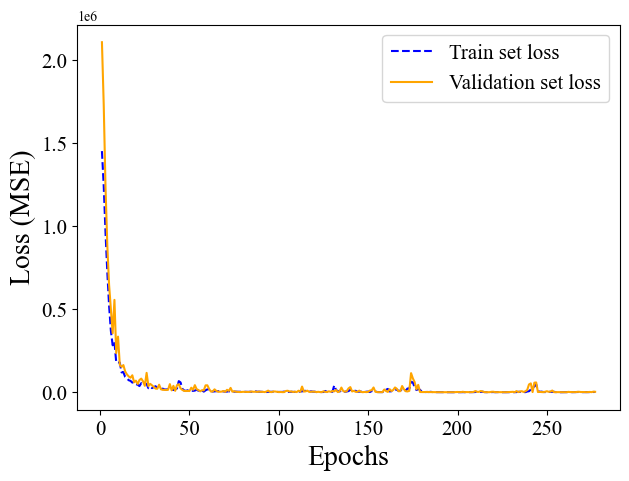

In [17]:
# let's see the training and validation accuracy by epoch
plt.figure(figsize=(7,5))

# Set the font to New Times Roman for all elements
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

# let's see the training and validation accuracy by epoch
history_dict = history.history
loss_values = history_dict['loss'] # you can change this
val_loss_values = history_dict['val_loss'] # you can also change this
epochs = range(1, len(loss_values) + 1) # range of X (no. of epochs)
plt.plot(epochs, loss_values, 'blue', label='Train set loss', linestyle='--')
plt.plot(epochs, val_loss_values, 'orange', label='Validation set loss')
#plt.title('Training and testing loss')
plt.xlabel('Epochs', fontsize = 20)
plt.ylabel('Loss (MSE)', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(loc='upper right',fontsize = 15)
plt.show()

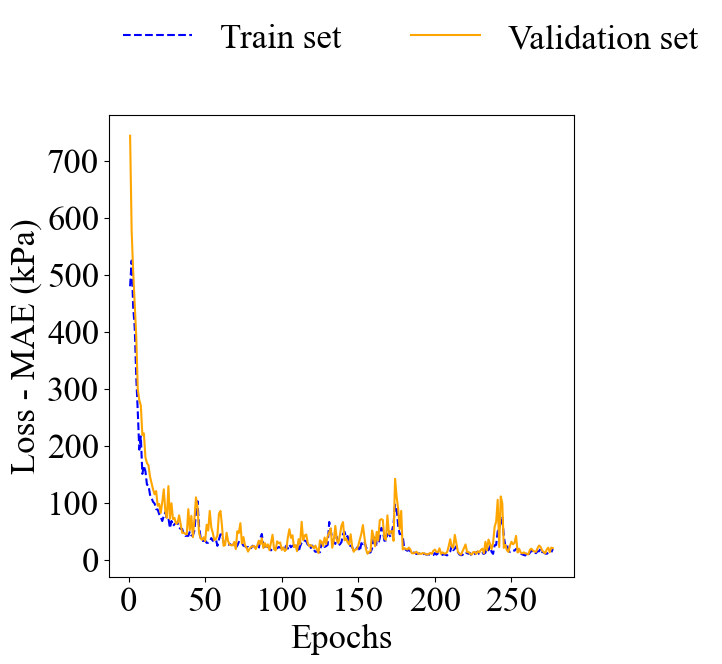

In [57]:
# let's see the training and validation accuracy by epoch
plt.figure(figsize=(6,6))

# Set the font to New Times Roman for all elements
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

loss_values1 = history_dict['mae'] # you can change this
val_loss_values1 = history_dict['val_mae'] # you can also change this
epochs = range(1, len(loss_values1) + 1) # range of X (no. of epochs)
plt.plot(epochs, loss_values1, 'blue', label='Train set', linestyle='--')
plt.plot(epochs, val_loss_values1, 'orange', label='Validation set')
#plt.title('Training and testing MAE')
plt.xlabel('Epochs', fontsize = 25)
plt.ylabel('Loss - MAE (kPa)', fontsize = 25)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.legend(loc=(0,0), bbox_to_anchor=(0, 1.1, 0.1, 0.1),fontsize = 25, ncol=2, frameon = False)
plt.savefig('MAE.png', dpi = 600, bbox_inches = 'tight')
plt.show()

In [47]:
# Convert arrays to DataFrames
df1 = pd.DataFrame(epochs)
df2 = pd.DataFrame(loss_values)
df3 = pd.DataFrame(val_loss_values)
df4 = pd.DataFrame(loss_values1)
df5 = pd.DataFrame(val_loss_values1)

# Concatenate DataFrames along the vertical axis
mse_df = pd.concat([df1, df2, df3], axis=1)
mae_df = pd.concat([df1, df4, df5], axis=1)

# Add labels to the DataFrame
mse_df.columns = ['Epochs', 'Train loss', 'Val loss']
mae_df.columns = ['Epochs', 'Train loss', 'Val loss']

# Save concatenated DataFrame to Excel file
mse_df.to_excel("MSE.xlsx", index=False)
mae_df.to_excel("MAE.xlsx", index=False)

# Part 4 - Make predictions

3/3 [==============================] - 0s 10ms/step


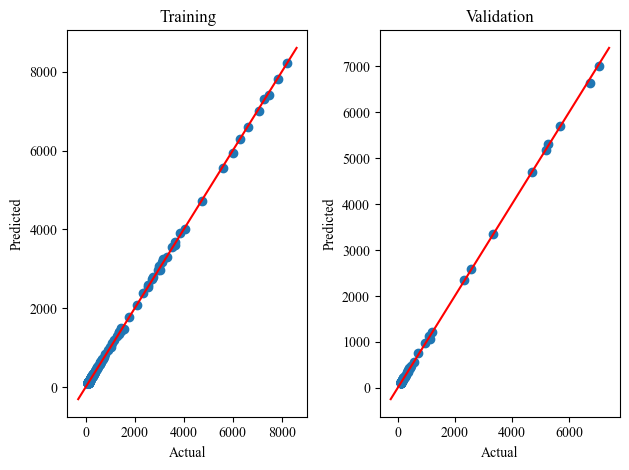

In [19]:
# scatterplot of actual vs. pred
# specify the dimensions 
fig, axes = plt.subplots(1,2) # 1 row, 2 columns

# this makes the individual subplots
# Training Results
axes[0].scatter(x=y_train, y=ann.predict(X_train)) #first row, first entry (left top)
axes[0].set_xlabel("Actual", fontsize=10)
axes[0].set_ylabel("Predicted",  fontsize=10)
axes[0].set_title("Training")
# add 45 deg line
x = np.linspace(*axes[0].get_xlim())
axes[0].plot(x, x, color='red')
# Validation Results
axes[1].scatter(x=y_val, y=ann.predict(X_val)) # first row, second entry (right top)
axes[1].set_xlabel("Actual", fontsize=10)
axes[1].set_ylabel("Predicted",  fontsize=10)
axes[1].set_title("Validation")
# add 45 deg line
x = np.linspace(*axes[1].get_xlim())
axes[1].plot(x, x, color='red')

# tight layout
fig.tight_layout()

# show the plot
plt.show()

In [20]:
y_pred = ann.predict(X_test)
np.set_printoptions(precision=2)
#print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

3/3 [==============================] - 0s 0s/step


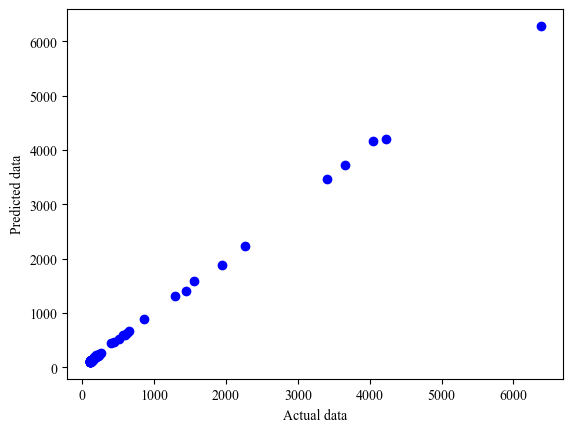

In [21]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred, color="blue")
#plt.plot ([0,4000],[0,4000], color = "red")
#plt.axis ([0,4000,0,4000])
plt.xlabel ('Actual data')
plt.ylabel ('Predicted data')
plt.show()

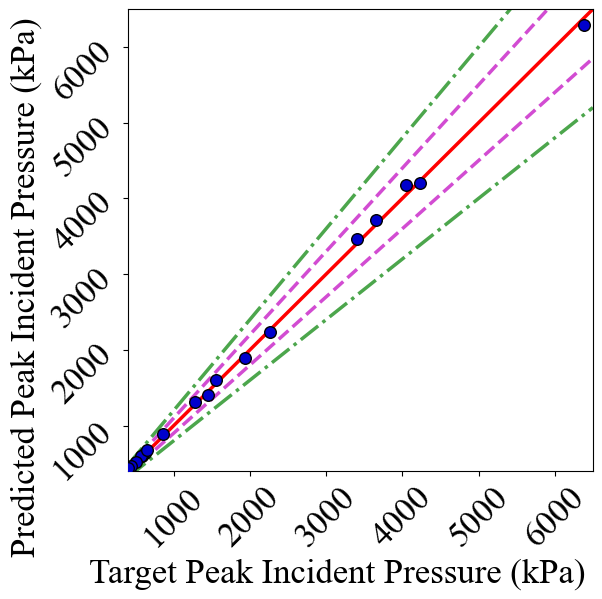

In [37]:
from sklearn.metrics import r2_score
# Initialize layout
fig1, ax1 = plt.subplots(figsize = (6, 6))

# Add scatterplot
ax1.scatter(y_test, y_pred, s=70, alpha=1, edgecolors="k",c='mediumblue',zorder=5, label = 'Points')

# Set the font to New Times Roman for all elements
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

# Set ylabel with adjusted position
ax1.set_ylabel('Predicted Peak Incident Pressure (kPa)',fontsize = 25, y=0.4)
ax1.set_xlabel('Target Peak Incident Pressure (kPa)',fontsize = 25, x=0.45)

#plt.ylabel('Predicted Peak Incident Pressure (kPa)',fontsize = 23)
#plt.xlabel('Target Peak Incident Pressure (kPa)',fontsize = 25)
plt.xticks(fontsize = 25, rotation=45)
plt.yticks(fontsize = 25, rotation=45)


x1 = np.linspace(400,6500)

ax1.spines['left'].set_color('black')        # setting up Y-axis tick color to red
ax1.spines['bottom'].set_color('black')   #setting up above X-axis tick color to red

plt.plot(x1, x1, 'Red', label='45\N{DEGREE SIGN} line',lw=2.5,alpha=1)
plt.plot(x1, 1.1*x1, '--m', label='\u00B110% Error',lw=2.5,alpha=0.7)
plt.plot(x1, 0.9*x1,'m', linestyle='--',lw=2.5,alpha=0.7)
plt.plot(x1, 1.2*x1, '-.g', label='\u00B120% Error',lw=2.5,alpha=0.7)
plt.plot(x1, 0.8*x1,'-.g',lw=2.5,alpha=0.7)

plt.ylim(400, 6500)
plt.xlim(400, 6500)
#plt.legend(loc='lower right',fontsize = 25)

#plt.grid()
plt.savefig('plot1.png', dpi = 600, bbox_inches = 'tight')
plt.show()

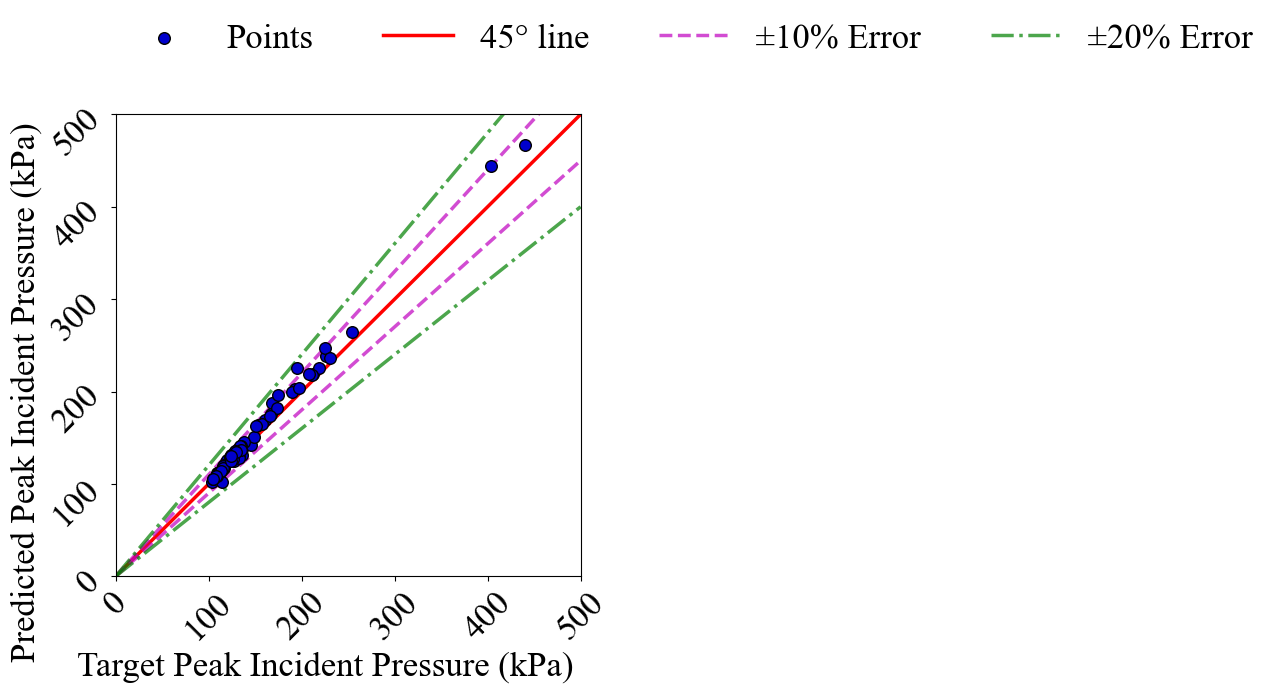

In [40]:
from sklearn.metrics import r2_score
# Initialize layout
fig2, ax2 = plt.subplots(figsize = (6, 6))

# Add scatterplot
ax2.scatter(y_test, y_pred, s=70, alpha=1, edgecolors="k",c='mediumblue',zorder=5, label = 'Points')

# Set the font to New Times Roman for all elements
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

# Set ylabel with adjusted position
ax2.set_ylabel('Predicted Peak Incident Pressure (kPa)',fontsize = 25, y=0.4)
ax2.set_xlabel('Target Peak Incident Pressure (kPa)',fontsize = 25, x=0.45)

#plt.ylabel('Predicted Peak Incident Pressure (kPa)',fontsize = 25)
#plt.xlabel('Actual Peak Incident Pressure (kPa)',fontsize = 25)
plt.xticks(fontsize = 25, rotation=45)
plt.yticks(fontsize = 25, rotation=45)


x1 = np.linspace(0,500)

plt.plot(x1, x1, 'Red', label='45\N{DEGREE SIGN} line',lw=2.5,alpha=1)
plt.plot(x1, 1.1*x1, '--m', label='\u00B110% Error',lw=2.5,alpha=0.7)
plt.plot(x1, 0.9*x1,'m', linestyle='--',lw=2.5,alpha=0.7)
plt.plot(x1, 1.2*x1, '-.g', label='\u00B120% Error',lw=2.5,alpha=0.7)
plt.plot(x1, 0.8*x1,'-.g',lw=2.5,alpha=0.7)

plt.ylim(0, 500)
plt.xlim(0, 500)
plt.legend(loc=(0,0), bbox_to_anchor=(0, 1.1, 0.1, 0.1),fontsize = 25, ncol=4, frameon = False)

#plt.grid()

ax1.spines['left'].set_color('black')        # setting up Y-axis tick color to red
ax1.spines['bottom'].set_color('black')         #setting up above X-axis tick color to red

plt.savefig('plot2.png', dpi = 600, bbox_inches = 'tight')

In [56]:
# Convert arrays to DataFrames with column labels
X_test_df = pd.DataFrame(X_test, columns = ['Explosive mass', 'Standoff distance', 'Comp B', 'TNT'])
y_test_df = pd.DataFrame(y_test, columns = ['test'])
y_pred_df = pd.DataFrame(y_pred, columns = ['pred'])

# Concatenate DataFrames along the vertical axis
pred_df = pd.concat([X_test_df, y_test_df, y_pred_df], axis=1)

# Save concatenated DataFrame to Excel file
pred_df.to_excel('pred_df.xlsx', index=False)

In [48]:
trainpreds = ann.predict(X_train)

from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_train, trainpreds)) # train
print(mean_absolute_error(y_test, y_pred)) # test

13/13 [==============================] - 0s 3ms/step
9.30784591616888
13.036164203086587


In [49]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print (r2)

0.9994733239280333


In [50]:
r2_train = r2_score(y_train, trainpreds)
print (r2_train)

0.9998172254066697


In [51]:
count1 = 0
for i in range(len(y_pred)):
    line1 = y_pred[i] - 0.9*y_test[i]
    line2 = y_pred[i] - 1.1*y_test[i]
    #print ('line 1 ', line1)
    #print ('line 2 ', line2)
    mask1 = (line1 > 0) & (line2 < 0)
    #print (mask)
    count1 = np.sum(mask1+count1)
    #print (count)

count2 = 0
for j in range(len(y_pred)):
    line3 = y_pred[j] - 0.8*y_test[j]
    line4 = y_pred[j] - 1.2*y_test[j]
    mask2 = (line3 > 0) & (line4 < 0)
    count2 = np.sum(mask2+count2)


count3 = 0    
for k in range(len(y_pred)):
    line5 = y_pred[k] - 0.8*y_test[k]
    line6 = y_pred[k] - 1.2*y_test[k]
    mask3 = (line5 < 0) or (line6 > 0)
    count3 = np.sum(mask3+count3)
   

print ('Within 10% margin', format((count1/len (y_pred)),'.2%'))
print ('Within 20% margin', format((count2/len (y_pred)),'.2%'))
print ('Out of 20% margin', format((count3/len (y_pred)),'.2%'))

Within 10% margin 94.38%
Within 20% margin 100.00%
Out of 20% margin 0.00%


In [52]:
adj_r2 = 1 - ((1 - r2) * (len(X_test) - 1) / (len(X_test) - len (X_test[0]) - 1))
print (adj_r2)

0.9994482441150826


In [53]:
import math
from sklearn.metrics import mean_squared_error

math.sqrt(mean_squared_error(y_test, y_pred))

23.904824544698013

In [54]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_test, y_pred)

13.036164203086587

In [55]:
ann.save('Peak_Pressure_ANN_4_final.h5')

D:\Anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Load saved model

In [8]:
ann = load_model('Peak_Pressure_ANN_4_final.h5')

## SHAP

In [6]:
dataset = pd.read_excel('PDataset_adj.xlsx')
dataset = pd.get_dummies(dataset, columns=['Explosive type'])
y = dataset[('Peak incident pressure')]
X = dataset.drop('Peak incident pressure', axis=1)
print (X)

     Explosive mass  Standoff distance  Explosive type_Composition B  \
0               0.5                1.0                             0   
1               0.5                1.5                             0   
2               0.5                2.5                             0   
3               0.5                3.5                             0   
4               0.5                4.5                             0   
..              ...                ...                           ...   
583            25.0               19.5                             1   
584            25.0               20.0                             1   
585            25.0                2.5                             1   
586            25.0                3.5                             1   
587            25.0                4.5                             1   

     Explosive type_TNT  
0                     1  
1                     1  
2                     1  
3                     1  
4    

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=71)
X_val, X_test, y_val, y_test = train_test_split(X_test,
                                                y_test,
                                                test_size=0.5,
                                                random_state=71)

In [8]:
import shap
explainer = shap.KernelExplainer(ann.predict, X_train)
shap_values = explainer.shap_values(X_train)

13/13 [==============================] - 0s 3ms/step


Using 411 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/411 [00:00<?, ?it/s]

180/180 [==============================] - 1s 3ms/step


In [9]:
import matplotlib as mpl
cmap = (mpl.colors.ListedColormap(['blue','orange', 'red'])
        .with_extremes(under='yellow', over='red'))

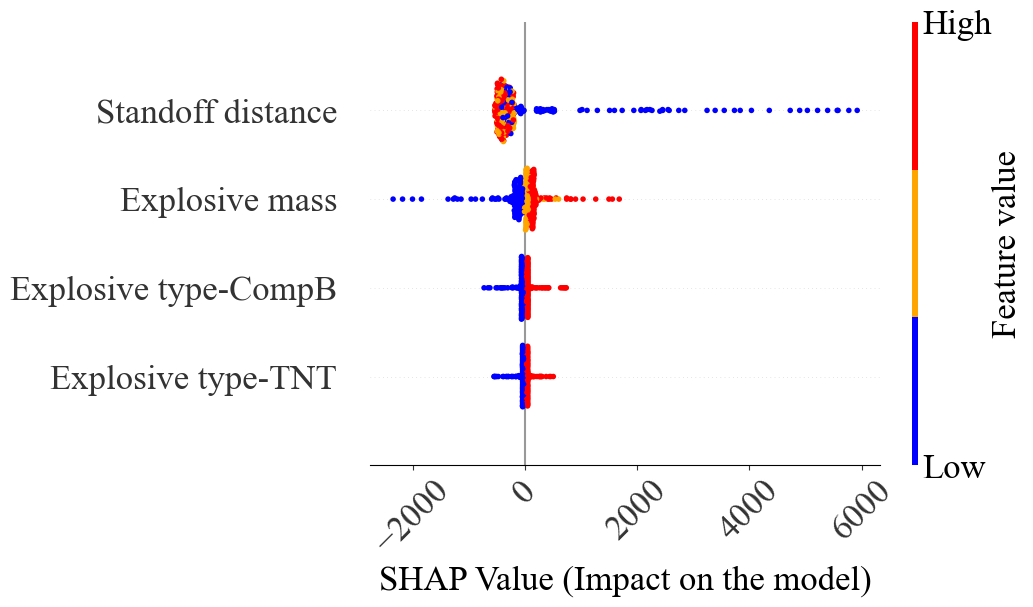

In [11]:
features = ['Explosive mass', 'Standoff distance', 'Explosive type-CompB', 'Explosive type-TNT', ]
shap.summary_plot(shap_values[0], X_train, show=False, feature_names=features, cmap=cmap, plot_type='dot')
fig = plt.gcf()
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

plt.gcf().set_size_inches(9,6)
plt.xlabel("SHAP Value (Impact on the model)", fontsize=25)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25, rotation=45)

# Get colorbar
cb_ax = fig.axes[1] 

# Modifying color bar parameters
cb_ax.tick_params(labelsize=25)
cb_ax.set_ylabel("Feature value", fontsize=25)
plt.savefig('SHAP1.png', dpi = 600, bbox_inches = 'tight')
plt.show()

In [12]:
#Waterfall Plot (for an instance)
explainer2 = shap.Explainer(ann.predict, X_test)
#X_test.columns=features
shap_values2 = explainer2(X_test)

13/13 [==============================] - 0s 2ms/step


ExactExplainer explainer:  26%|██▌       | 23/89 [00:00<?, ?it/s]

12/12 [==============================] - 0s 3ms/step


ExactExplainer explainer:  28%|██▊       | 25/89 [00:10<00:09,  6.74it/s]

13/13 [==============================] - 0s 2ms/step


ExactExplainer explainer:  29%|██▉       | 26/89 [00:10<00:12,  4.91it/s]

12/12 [==============================] - 0s 3ms/step


ExactExplainer explainer:  30%|███       | 27/89 [00:11<00:15,  4.00it/s]

13/13 [==============================] - 0s 2ms/step


ExactExplainer explainer:  31%|███▏      | 28/89 [00:11<00:15,  3.89it/s]

13/13 [==============================] - 0s 3ms/step


ExactExplainer explainer:  33%|███▎      | 29/89 [00:11<00:16,  3.72it/s]

13/13 [==============================] - 0s 2ms/step


ExactExplainer explainer:  34%|███▎      | 30/89 [00:11<00:16,  3.51it/s]

13/13 [==============================] - 0s 2ms/step


ExactExplainer explainer:  35%|███▍      | 31/89 [00:12<00:16,  3.55it/s]

13/13 [==============================] - 0s 3ms/step


ExactExplainer explainer:  36%|███▌      | 32/89 [00:12<00:15,  3.61it/s]

13/13 [==============================] - 0s 1ms/step


ExactExplainer explainer:  37%|███▋      | 33/89 [00:12<00:14,  3.79it/s]

13/13 [==============================] - 0s 2ms/step


ExactExplainer explainer:  38%|███▊      | 34/89 [00:12<00:14,  3.71it/s]

13/13 [==============================] - 0s 2ms/step


ExactExplainer explainer:  39%|███▉      | 35/89 [00:13<00:14,  3.62it/s]

13/13 [==============================] - 0s 1ms/step


ExactExplainer explainer:  40%|████      | 36/89 [00:13<00:14,  3.59it/s]

13/13 [==============================] - 0s 2ms/step


ExactExplainer explainer:  42%|████▏     | 37/89 [00:13<00:13,  3.77it/s]

13/13 [==============================] - 0s 3ms/step


ExactExplainer explainer:  43%|████▎     | 38/89 [00:14<00:13,  3.70it/s]

13/13 [==============================] - 0s 2ms/step


ExactExplainer explainer:  44%|████▍     | 39/89 [00:14<00:13,  3.75it/s]

13/13 [==============================] - 0s 1ms/step


ExactExplainer explainer:  45%|████▍     | 40/89 [00:14<00:13,  3.70it/s]

13/13 [==============================] - 0s 2ms/step


ExactExplainer explainer:  46%|████▌     | 41/89 [00:14<00:13,  3.64it/s]

13/13 [==============================] - 0s 1ms/step


ExactExplainer explainer:  47%|████▋     | 42/89 [00:15<00:12,  3.65it/s]

13/13 [==============================] - 0s 4ms/step


ExactExplainer explainer:  48%|████▊     | 43/89 [00:15<00:13,  3.50it/s]

13/13 [==============================] - 0s 2ms/step


ExactExplainer explainer:  49%|████▉     | 44/89 [00:15<00:12,  3.68it/s]

13/13 [==============================] - 0s 1ms/step


ExactExplainer explainer:  51%|█████     | 45/89 [00:15<00:11,  3.85it/s]

13/13 [==============================] - 0s 2ms/step


ExactExplainer explainer:  52%|█████▏    | 46/89 [00:16<00:11,  3.72it/s]

13/13 [==============================] - 0s 2ms/step


ExactExplainer explainer:  53%|█████▎    | 47/89 [00:16<00:11,  3.67it/s]

13/13 [==============================] - 0s 3ms/step


ExactExplainer explainer:  54%|█████▍    | 48/89 [00:16<00:10,  3.75it/s]

12/12 [==============================] - 0s 1ms/step


ExactExplainer explainer:  55%|█████▌    | 49/89 [00:17<00:10,  3.73it/s]

13/13 [==============================] - 0s 3ms/step


ExactExplainer explainer:  56%|█████▌    | 50/89 [00:17<00:10,  3.83it/s]

13/13 [==============================] - 0s 1ms/step


ExactExplainer explainer:  57%|█████▋    | 51/89 [00:17<00:10,  3.68it/s]

13/13 [==============================] - 0s 3ms/step


ExactExplainer explainer:  58%|█████▊    | 52/89 [00:17<00:10,  3.52it/s]

13/13 [==============================] - 0s 3ms/step


ExactExplainer explainer:  60%|█████▉    | 53/89 [00:18<00:10,  3.51it/s]

13/13 [==============================] - 0s 3ms/step


ExactExplainer explainer:  61%|██████    | 54/89 [00:18<00:09,  3.60it/s]

13/13 [==============================] - 0s 3ms/step


ExactExplainer explainer:  62%|██████▏   | 55/89 [00:18<00:09,  3.42it/s]

13/13 [==============================] - 0s 1ms/step


ExactExplainer explainer:  63%|██████▎   | 56/89 [00:19<00:09,  3.40it/s]

13/13 [==============================] - 0s 3ms/step


ExactExplainer explainer:  64%|██████▍   | 57/89 [00:19<00:09,  3.50it/s]

13/13 [==============================] - 0s 2ms/step


ExactExplainer explainer:  65%|██████▌   | 58/89 [00:19<00:08,  3.46it/s]

13/13 [==============================] - 0s 1ms/step


ExactExplainer explainer:  66%|██████▋   | 59/89 [00:19<00:08,  3.43it/s]

13/13 [==============================] - 0s 3ms/step


ExactExplainer explainer:  67%|██████▋   | 60/89 [00:20<00:08,  3.31it/s]

13/13 [==============================] - 0s 3ms/step


ExactExplainer explainer:  69%|██████▊   | 61/89 [00:20<00:08,  3.27it/s]

13/13 [==============================] - 0s 3ms/step


ExactExplainer explainer:  70%|██████▉   | 62/89 [00:20<00:08,  3.20it/s]

13/13 [==============================] - 0s 3ms/step


ExactExplainer explainer:  71%|███████   | 63/89 [00:21<00:08,  3.19it/s]

13/13 [==============================] - 0s 2ms/step


ExactExplainer explainer:  72%|███████▏  | 64/89 [00:21<00:07,  3.17it/s]

12/12 [==============================] - 0s 3ms/step


ExactExplainer explainer:  73%|███████▎  | 65/89 [00:21<00:07,  3.26it/s]

13/13 [==============================] - 0s 3ms/step


ExactExplainer explainer:  74%|███████▍  | 66/89 [00:22<00:07,  3.24it/s]

13/13 [==============================] - 0s 3ms/step


ExactExplainer explainer:  75%|███████▌  | 67/89 [00:22<00:06,  3.17it/s]

13/13 [==============================] - 0s 3ms/step


ExactExplainer explainer:  76%|███████▋  | 68/89 [00:22<00:06,  3.12it/s]

13/13 [==============================] - 0s 3ms/step


ExactExplainer explainer:  78%|███████▊  | 69/89 [00:23<00:06,  3.08it/s]

12/12 [==============================] - 0s 1ms/step


ExactExplainer explainer:  79%|███████▊  | 70/89 [00:23<00:05,  3.30it/s]

13/13 [==============================] - 0s 2ms/step


ExactExplainer explainer:  80%|███████▉  | 71/89 [00:23<00:05,  3.49it/s]

13/13 [==============================] - 0s 710us/step


ExactExplainer explainer:  81%|████████  | 72/89 [00:23<00:04,  3.54it/s]

13/13 [==============================] - 0s 2ms/step


ExactExplainer explainer:  82%|████████▏ | 73/89 [00:24<00:04,  3.60it/s]

13/13 [==============================] - 0s 3ms/step


ExactExplainer explainer:  83%|████████▎ | 74/89 [00:24<00:04,  3.39it/s]

13/13 [==============================] - 0s 3ms/step


ExactExplainer explainer:  84%|████████▍ | 75/89 [00:24<00:04,  3.41it/s]

13/13 [==============================] - 0s 1ms/step


ExactExplainer explainer:  85%|████████▌ | 76/89 [00:25<00:03,  3.66it/s]

13/13 [==============================] - 0s 3ms/step


ExactExplainer explainer:  87%|████████▋ | 77/89 [00:25<00:03,  3.51it/s]

13/13 [==============================] - 0s 3ms/step


ExactExplainer explainer:  88%|████████▊ | 78/89 [00:25<00:03,  3.31it/s]

13/13 [==============================] - 0s 3ms/step


ExactExplainer explainer:  89%|████████▉ | 79/89 [00:26<00:03,  3.22it/s]

13/13 [==============================] - 0s 2ms/step


ExactExplainer explainer:  90%|████████▉ | 80/89 [00:26<00:02,  3.32it/s]

13/13 [==============================] - 0s 3ms/step


ExactExplainer explainer:  91%|█████████ | 81/89 [00:26<00:02,  3.28it/s]

12/12 [==============================] - 0s 2ms/step


ExactExplainer explainer:  92%|█████████▏| 82/89 [00:26<00:02,  3.21it/s]

12/12 [==============================] - 0s 1ms/step


ExactExplainer explainer:  93%|█████████▎| 83/89 [00:27<00:01,  3.34it/s]

13/13 [==============================] - 0s 1ms/step


ExactExplainer explainer:  94%|█████████▍| 84/89 [00:27<00:01,  3.42it/s]

13/13 [==============================] - 0s 3ms/step


ExactExplainer explainer:  96%|█████████▌| 85/89 [00:27<00:01,  3.40it/s]

13/13 [==============================] - 0s 2ms/step


ExactExplainer explainer:  97%|█████████▋| 86/89 [00:28<00:00,  3.50it/s]

13/13 [==============================] - 0s 3ms/step


ExactExplainer explainer:  98%|█████████▊| 87/89 [00:28<00:00,  3.58it/s]

12/12 [==============================] - 0s 3ms/step


ExactExplainer explainer:  99%|█████████▉| 88/89 [00:28<00:00,  3.70it/s]

13/13 [==============================] - 0s 2ms/step


ExactExplainer explainer: 100%|██████████| 89/89 [00:28<00:00,  3.59it/s]

13/13 [==============================] - 0s 1ms/step


ExactExplainer explainer: 90it [00:29,  2.30it/s]                        


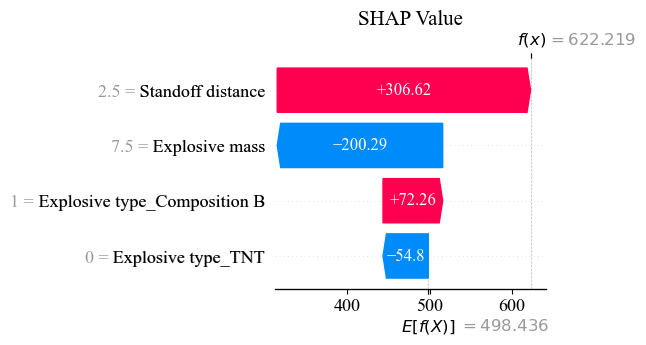

In [13]:
shap.waterfall_plot(shap_values2[21], show=False)
#fig2, ax2 = plt.subplots()
plt.gcf()
plt.gcf().set_size_inches(3.5,3)
plt.rcParams['font.weight'] = 'normal'
plt.xlabel('SHAP Value', fontsize = 15)

#ax2.set_xlabel('SHAP Value', fontsize = 25)
#ax2.xaxis.set_label_coords(0.5, 0.1)
plt.savefig('SHAP2.png', dpi = 600, bbox_inches = 'tight')
plt.show()

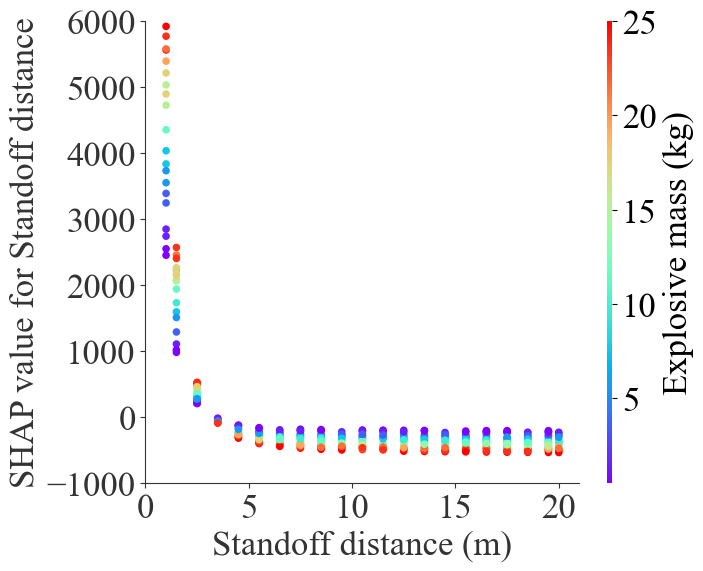

In [14]:
#Partial Dependenace Plot
shap.dependence_plot(1, shap_values[0], X_train, feature_names = features, show=False, cmap = "rainbow", dot_size = 30)
fig3 = plt.gcf()
plt.gcf().set_size_inches(7,6)
plt.ylabel("SHAP value for Standoff distance", fontsize = 25)
plt.xlabel("Standoff distance (m)",fontsize = 25)
plt.yticks(fontsize = 25)
plt.xticks(ticks = [0, 5, 10, 15, 20],fontsize = 25)
plt.xlim (0, 21)
plt.ylim (-1000, 6000)
#plt.grid (visible = True, which = 'major', axis = 'y')

# Get colorbar
cb_ax3 = fig3.axes[1] 

# Modifying color bar parameters
cb_ax3.tick_params(labelsize=25)
cb_ax3.set_ylabel("Explosive mass (kg)", fontsize=25)
plt.savefig('SHAP3.png', dpi = 600, bbox_inches = 'tight')
plt.show()

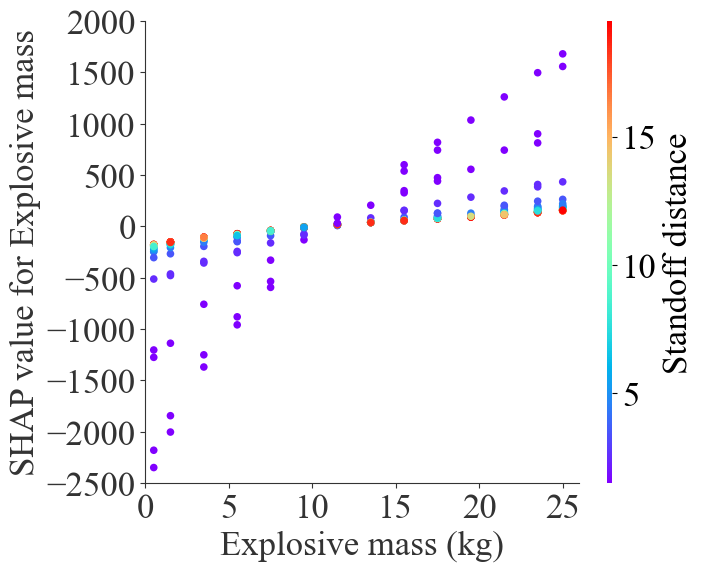

In [15]:
#Partial Dependenace Plot
shap.dependence_plot(0, shap_values[0], X_train, feature_names = features, show=False, cmap = "rainbow", dot_size = 30)
fig4 = plt.gcf()
plt.gcf().set_size_inches(7,6)
plt.ylabel("SHAP value for Explosive mass", fontsize = 25)
plt.xlabel("Explosive mass (kg)",fontsize = 25)
plt.yticks(fontsize = 25)
plt.xticks(ticks = [0, 5, 10, 15, 20, 25],fontsize = 25)
plt.xlim (0, 26)
plt.ylim (-2500, 2000)
#plt.grid (visible = True, which = 'major', axis = 'y')

# Get colorbar
cb_ax4 = fig4.axes[1] 

# Modifying color bar parameters
cb_ax4.tick_params(labelsize=25)
cb_ax4.set_ylabel("Standoff distance", fontsize=25)
plt.savefig('SHAP4.png', dpi = 600, bbox_inches = 'tight')
plt.show()

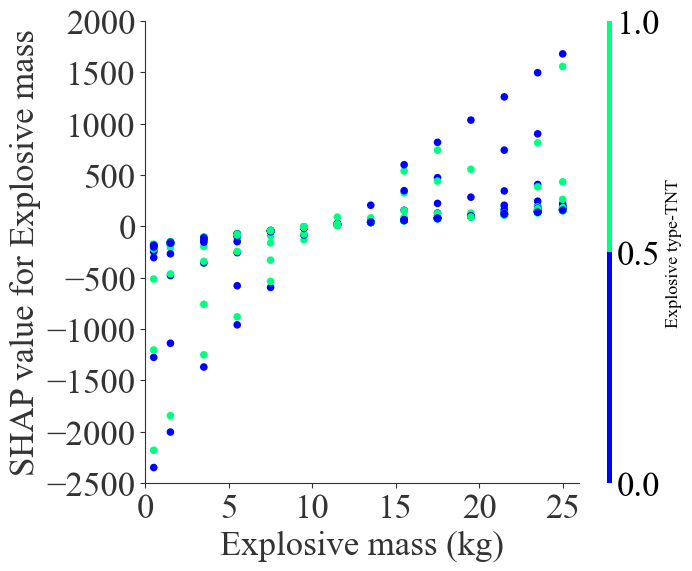

In [41]:
#Partial Dependenace Plot
shap.dependence_plot(ind = 'Explosive mass',
                     shap_values = shap_values[0],
                     features = X_train,
                     feature_names = features,
                     interaction_index = 'Explosive type-TNT',
                     show=False, cmap=plt.get_cmap("winter"), dot_size = 30)
fig5 = plt.gcf()
plt.gcf().set_size_inches(7,6)
plt.ylabel("SHAP value for Explosive mass", fontsize = 25)
plt.xlabel("Explosive mass (kg)",fontsize = 25)
plt.yticks(fontsize = 25)
plt.xticks(ticks = [0, 5, 10, 15, 20, 25],fontsize = 25)
plt.xlim (0, 26)
plt.ylim (-2500, 2000)
#plt.grid (visible = True, which = 'major', axis = 'y')

# Get colorbar
cb_ax5 = fig5.axes[1] 

# Modifying color bar parameters
cb_ax5.tick_params(labelsize=25)
#cb_ax5.set_ylabel("Standoff distance", fontsize=25)
plt.savefig('SHAP5.png', dpi = 600, bbox_inches = 'tight')
plt.show()